In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import LinearLR
import numpy as np
import pandas as pd
import os
import cv2
from google.colab.patches import cv2_imshow

### 데이터셋 가져오기

In [2]:
from pandas.core.frame import DataFrame
paths = []
dataset_type = []
labels = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/고모부_머신러닝/dogncat'):
    for filename in filenames:
        filepath = dirname + '/' + filename
        paths.append(filepath)

        if '/training_set' in filepath:
            dataset_type.append('train')

        elif '/test_set' in filepath:
            dataset_type.append('test')

        if 'dogs' in filepath:
            labels.append('DOG')
        
        elif 'cats' in filepath:
            labels.append('CAT')

In [3]:
# Cat n Dog 데이터를 데이터 프레임으로 만들기(path, datatype, label)
cnd_df = pd.DataFrame({'path' : paths, 'type' : dataset_type, 'label' : labels})

# '.jpg'를 포함하는 path만 df로 만들기
filter = cnd_df['path'].str.contains('.jpg') 
cnd_df = cnd_df[filter]

# train, testset으로 분리
train_df = cnd_df[cnd_df['type'] == 'train']
test_df = cnd_df[cnd_df['type'] == 'test']

# train 데이터, test 데이터
train_path = train_df['path'].values
test_path = test_df['path'].values

# train label, test label
train_label = train_df['label'].values
test_label = test_df['label'].values

# categorical variable -> numeric
train_label_indices = train_df['label'].replace(['CAT', 'DOG'], [0,1]).values
test_label_indices = test_df['label'].replace(['CAT', 'DOG'], [0,1]).values


In [27]:
train_df[4000:4100]

,path,type,label
6026,/content/drive/MyDrive/고모부_머신러닝/dognc...,train,DOG
6027,/content/drive/MyDrive/고모부_머신러닝/dognc...,train,DOG
6028,/content/drive/MyDrive/고모부_머신러닝/dognc...,train,DOG
6029,/content/drive/MyDrive/고모부_머신러닝/dognc...,train,DOG
6030,/content/drive/MyDrive/고모부_머신러닝/dognc...,train,DOG
...,...,...,...
6121,/content/drive/MyDrive/고모부_머신러닝/dognc...,train,DOG
6122,/content/drive/MyDrive/고모부_머신러닝/dognc...,train,DOG
6123,/content/drive/MyDrive/고모부_머신러닝/dognc...,train,DOG
6124,/content/drive/MyDrive/고모부_머신러닝/dognc...,train,DOG


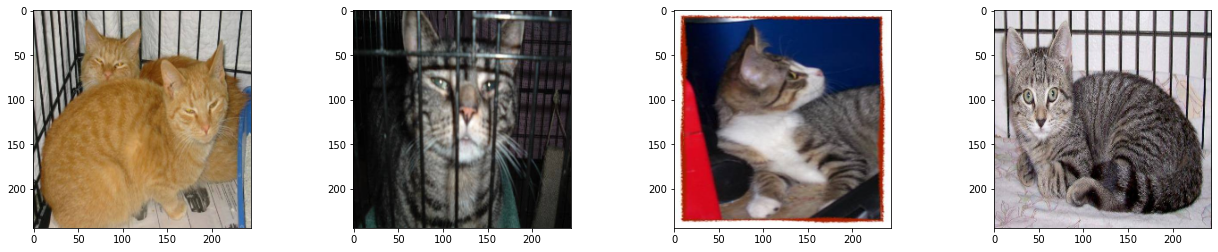

In [30]:
import matplotlib.pyplot as plt
nrows=1
ncols=4
figure, axes = plt.subplots(figsize=(22,4), nrows=1, ncols=4)
for i in range(ncols):
    image = cv2.cvtColor(cv2.imread(train_path[i]), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (244,244))
    axes[i].imshow(image)

### 데이터 셋 만들기

In [69]:
class MyDataset(Dataset):
    def __init__(self, path, label):
        super(MyDataset, self).__init__()
        self.paths = path
        self.labels = label

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        print(self.paths[idx])
        image = cv2.cvtColor(cv2.imread(self.paths[idx]), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (244,244))
        image = np.asarray(image, dtype=np.float32).transpose(2,0,1)
        max = np.amax(image)
        min = np.amin(image)
        min_max_image = (image - min) / (max - min)
        # cv2_imshow(image)

        if self.labels is not None:
            print(self.labels[idx])
            label = self.labels[idx]

        return min_max_image, label



In [70]:
cnd_dataset = MyDataset(train_path, train_label_indices)
loader = DataLoader(cnd_dataset, batch_size=10, shuffle=True)
image_data, label_data = next(iter(loader))
print(image_data.view(image_data.size(0), -1))
print(label_data)

/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/dogs/dog.1863.jpg
1
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/cats/cat.3524.jpg
0
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/dogs/dog.1562.jpg
1
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/dogs/dog.1742.jpg
1
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/cats/cat.3547.jpg
0
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/dogs/dog.1100.jpg
1
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/cats/cat.470.jpg
0
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/dogs/dog.2646.jpg
1
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/dogs/dog.483.jpg
1
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/cats/cat.3945.jpg
0
tensor([[0.2824, 0.1725, 0.2078,  ..., 0.6392, 0.698

### 모델 만들기

In [76]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.hidden1 = nn.Conv2d(3, 5, kernel_size=3, padding='same')
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(5*244*244, 2)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        print('input shape:', x.shape)
        print(' input max : ', torch.amax(x, dim=(1,2,3)))
        print(' input min : ', torch.amin(x, dim=(1,2,3)))
        print(' input l2norm : ', torch.linalg.vector_norm(x, dim=(1,2,3)))

        # hidden layer
        conv = self.hidden1(x)
        print('conv result shape :', conv.shape)
        print(' conv max : ', torch.amax(conv, dim=(1,2,3)))
        print(' conv min : ', torch.amin(conv, dim=(1,2,3)))
        print(' conv l2norm : ', torch.linalg.vector_norm(conv, dim=(1,2,3)))
        conv_out = self.relu(conv)
        print('conv_out shape :', conv_out.shape)
        print(' conv_out max : ', torch.amax(conv_out, dim=(1,2,3)))
        print(' conv_out min : ', torch.amin(conv_out, dim=(1,2,3)))
        print(' conv_out l2norm : ', torch.linalg.vector_norm(conv_out, dim=(1,2,3)))

        fc_input = conv_out.view(conv_out.size(0), -1)
        print('fc_input shape :', fc_input.shape)
        print(' fc_input max : ', torch.amax(fc_input, dim=1))
        print(' fc_input min : ', torch.amin(fc_input, dim=1))
        print(' fc_input l2norm : ', torch.linalg.vector_norm(fc_input, dim=1))

        # output layer
        fc_logit = self.fc1(fc_input)
        print('fc_logit shape :', fc_logit.shape)
        print(' fc_logit max : ', torch.amax(fc_logit, dim=1))
        print(' fc_logit min : ', torch.amin(fc_logit, dim=1))
        print(' fc_logit l2norm : ', torch.linalg.vector_norm(fc_logit, dim=1))
        # fc_output = self.softmax(fc_logit)
        # print('fc_output :', fc_output)
        # print('fc_output shape :', fc_output.shape)
        # print(' fc_output max : ', torch.amax(fc_output, dim=1))
        # print(' fc_output min : ', torch.amin(fc_output, dim=1))
        # print(' fc_output l2norm : ', torch.linalg.vector_norm(fc_output, dim=1))

        return fc_logit
        

In [77]:
model = CNN()
model

CNN(
  (hidden1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu): ReLU()
  (fc1): Linear(in_features=297680, out_features=2, bias=True)
)

### Loss funtion 설정

In [78]:
loss_fn = nn.CrossEntropyLoss(reduction='mean')
# for _ in range(5):
#     image_data, label_data = next(iter(loader))
#     hyphothesis = model(image_data)
#     loss = loss_fn(hyphothesis, label_data)
#     print('loss : \n', loss)

### optimizer, lr_scheduler 설정

In [79]:
optimizer = SGD(model.parameters(), lr=0.001)
scheduler = LinearLR(optimizer)

### Training

In [80]:
for i in range(10):
    print(f'--------- step{i+1} ---------')
    optimizer.zero_grad()
    train_image, train_label = next(iter(loader))
    print(train_image.view(train_image.size(0), -1))
    print(train_label)
    hyphothesis = model(train_image)
    print('hyphothesis :', hyphothesis)
    loss = loss_fn(hyphothesis, train_label)
    print('loss :', loss)
    loss.backward() # loss값을 각각의 파라미터에 대하여 미분하여 gradient를 계산하는 과정.
    print('gradient max',[torch.amax(param.grad) for param in model.parameters()])
    print('gradient min',[torch.amin(param.grad) for param in model.parameters()])
    print('gradient l2norm', [torch.linalg.vector_norm(param.grad) for param in model.parameters()])

    # print('max gradient :', torch.amax(torch.tensor([torch.amax(param.grad) for param in model.parameters()])))
    # print('min gradient :', torch.amin(torch.tensor([torch.amin(param.grad) for param in model.parameters()])))
    # print('l2norm gradient :', torch.linalg.vector_norm(torch.tensor([torch.linalg.vector_norm(param.grad) for param in model.parameters()])))
    print()
    optimizer.step() # 계산된 gradient로 파라미터를 업데이트
scheduler.step()
    

--------- step1 ---------
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/cats/cat.3770.jpg
0
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/cats/cat.424.jpg
0
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/dogs/dog.929.jpg
1
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/dogs/dog.1386.jpg
1
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/dogs/dog.761.jpg
1
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/cats/cat.1356.jpg
0
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/cats/cat.2162.jpg
0
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/cats/cat.996.jpg
0
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/cats/cat.140.jpg
0
/content/drive/MyDrive/고모부_머신러닝/dogncat/training_set/training_set/cats/cat.1287.jpg
0
tensor([[0.1451, 0.1451, 0.14

In [41]:
print(torch.amax(torch.tensor([torch.amax(param.grad) for param in model.parameters()])))
print(torch.amin(torch.tensor([torch.amin(param.grad) for param in model.parameters()])))
print(torch.linalg.vector_norm(torch.tensor([torch.linalg.vector_norm(param.grad) for param in model.parameters()])))

tensor(1.2529)
tensor(-1.2529)
tensor(12.7929)


### parameter update 공식은 반드시 외울 것
new parameter = formal parameter - lr * gradient

###gradient값을 출력하려고 할 때 어디에 출력하면 좋을까?
- gradient값이 계산되는 위치 = loss.backward()
- gradient값이 초기화되는 위치 = optimizer.zero_grad()
- 즉, gradient가 계산되고 gradient가 초기화되기 전인 loss.backward()와 optimizer.zero_grad()사이에 출력이 가능하다.



### optimizer.zero_grad()의 위치
- gradient값이 사용되는 곳 = optimizer.step()
- gradient값은 optimizer.step()이외에는 사용되는 곳이 없으므로 optimizer.step()이후에는 없애도 된다.

### step 중간에 loss값이 만단위로 훌쩍 뛰는 현상이 있었다. 그러다가 다시 줄어들긴 했지만... 왜?
- 이미지 데이터를 min - max normalization 해주었더니 위의 현상은 사라짐..

### 동일한 이미지를 계속 넣어줘도 loss값은 계속 변한다. 왜?
- 매 step마다 loss를 계산하고 optimizer.step()을 통해 파라미터를 업데이트 해준다. 따라서, 다음 step에서 동일한 이미지를 넣어줘도 뉴런에서 사용되는 파라미터 값은 달라진다. 